
# Customer Analysis 
This study aims to:
- understand customer purchase behaviours
- Customer acquisition Rate
- Customer retention Rate 

**Driving to Data driven Marketing.**

Load the neccessary packages.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

Change the WD and load the data

In [2]:
cd C:\Users\DMuturi\Desktop\Py Projects

C:\Users\DMuturi\Desktop\Py Projects


In [18]:
df= pd.read_excel('customers.xlsx')
df.head(5)

,Territory,Route,CustomerName,Date,Quantity
0,Nairobi North,KABATI,OPEN DOOR,2019-06-24,4
1,Nairobi South,MLOLONGO,MLOLONGO GAS EXPERTS,2019-06-24,2
2,Mt. Kenya,EMBU,MAMA NJERI SLOPES MAJENGO,2019-06-24,2
3,Nairobi South,MLOLONGO,POULINE,2019-06-24,11
4,Nairobi South,RONGAI 1,EXTRA GAS,2019-06-24,2


The data represents all customers daily cylinders purchases from $1^{st} Jan 2019$ to $24^{th} June 2019$

In [19]:
## View the data size
df.shape

(158350, 5)

In [20]:
#Counting the unique customers that we have served 
df.CustomerName.nunique()

8914

This data has $158350$ rows and $5$ features.  

We have been able to serve $8914$ total customers out of  $12351$  mapped customers which represents $72\%$.

We have $3437$ = $28\% $ of mapped customers that we have not been able to reach this year. 

WHY?

In [11]:
df.isna().sum()

Territory       0
Route           0
CustomerName    0
Date            0
Quantity        0
dtype: int64

## Cohort Analysis
*Cohort analysis is a subset of behavioral analytics that takes the data from a given data set and rather than looking at all users as one unit, it breaks them into related groups for analysis. These related groups, or cohorts, usually share common characteristics or experiences within a defined time-span.*


We break our data to different cohorts. New customers in each moth shall represent distinct cohorts.

Add two columns on the data:
 - The month for each purchase. **(PurchaseMonth)**
 - The month when the customer first bought from us. **(CohortGroup)**

In [21]:
### Creating a new dataset df1
df1=df
df1['PurchaseMonth'] = df.Date.apply(lambda x: x.strftime('%Y-%m')) ##Adding a purchase month column
df1.head()

,Territory,Route,CustomerName,Date,Quantity,PurchaseMonth
0,Nairobi North,KABATI,OPEN DOOR,2019-06-24,4,2019-06
1,Nairobi South,MLOLONGO,MLOLONGO GAS EXPERTS,2019-06-24,2,2019-06
2,Mt. Kenya,EMBU,MAMA NJERI SLOPES MAJENGO,2019-06-24,2,2019-06
3,Nairobi South,MLOLONGO,POULINE,2019-06-24,11,2019-06
4,Nairobi South,RONGAI 1,EXTRA GAS,2019-06-24,2,2019-06


Adding the Cohort Group colunm.

In [22]:
df1.set_index('CustomerName', inplace=True)

df1['CohortGroup'] = df1.groupby(level=0)['Date'].min().apply(lambda x: x.strftime('%Y-%m'))
df1.reset_index(inplace=True)
df1.head()

,CustomerName,Territory,Route,Date,Quantity,PurchaseMonth,CohortGroup
0,OPEN DOOR,Nairobi North,KABATI,2019-06-24,4,2019-06,2019-01
1,MLOLONGO GAS EXPERTS,Nairobi South,MLOLONGO,2019-06-24,2,2019-06,2019-02
2,MAMA NJERI SLOPES MAJENGO,Mt. Kenya,EMBU,2019-06-24,2,2019-06,2019-01
3,POULINE,Nairobi South,MLOLONGO,2019-06-24,11,2019-06,2019-02
4,EXTRA GAS,Nairobi South,RONGAI 1,2019-06-24,2,2019-06,2019-02


The **CohortGroups** represents the the month for the first purchase. eg, cohort group $2019-01
$ represents all the customers that made their first purchase on January.

In [23]:
grouped= df1.groupby(['CohortGroup','PurchaseMonth'])

## Count unique customers and total cylinders in each group

In [24]:
cohorts=grouped.agg({"CustomerName":pd.Series.nunique,
                    "Quantity":np.sum})
cohorts.rename(columns={"CustomerName":"TotalCustomers",
                        "Quantity":"TotalSales"}, inplace= True)
cohorts.head(10)

TotalCustomers  TotalSales
CohortGroup PurchaseMonth                            
2019-01     2019-01                  4579      239798
            2019-02                  3197      184485
            2019-03                  2919      161726
            2019-04                  2989      173131
            2019-05                  3449      204565
            2019-06                  3295      147827
2019-02     2019-02                   977       14640
            2019-03                   545       13112
            2019-04                   551       16154
            2019-05                   654       20088

#### Label the CohortPeriod for each CohortGroup
We want to look at how each cohort has behaved in the months following their first purchase, so we'll need to index each cohort to their first purchase month. For example, CohortPeriod = 1 will be the cohort's first month, CohortPeriod = 2 is their second, and so on.

The index ranges from $1$ to $6$ since we have six months

In [25]:
def cohort_period(df1):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df1['CohortPeriod'] = np.arange(len(df1)) + 1
    return df1


In [26]:
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalCustomers  TotalSales  CohortPeriod
CohortGroup PurchaseMonth                                          
2019-01     2019-01                  4579      239798             1
            2019-02                  3197      184485             2
            2019-03                  2919      161726             3
            2019-04                  2989      173131             4
            2019-05                  3449      204565             5

### Customer retention by cohort group

We want to see how customers have been changing in each cohort. How have we been retaining or losing the customers?

In [23]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

In [24]:
# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalCustomers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2019-01    4579
2019-02     977
2019-03     590
2019-04     902
2019-05    1331
Name: TotalCustomers, dtype: int64

This represents the cohort size, the number of new unique customer who puchased on made their first purchase on the given month. 

This could be interprated as the number of new customers we have been earning per month.

In [25]:
cohorts['TotalCustomers'].head()

CohortGroup  CohortPeriod
2019-01      1               4579
             2               3197
             3               2919
             4               2989
             5               3449
Name: TotalCustomers, dtype: int64

In [31]:
cohorts['TotalCustomers'].unstack(0).head(20)

CohortGroup,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
CohortPeriod,,,,,,
1,4579.0,977.0,590.0,902.0,1331.0,535.0
2,3197.0,545.0,333.0,445.0,604.0,NaN
3,2919.0,551.0,330.0,332.0,NaN,NaN
4,2989.0,654.0,283.0,NaN,NaN,NaN
5,3449.0,618.0,NaN,NaN,NaN,NaN
6,3295.0,NaN,NaN,NaN,NaN,NaN


####  What to Notes.....
1. The first row represents the new customers we have been gaining for the six months in this year. 
we have been earning  an avarage of $867$ customers each month. 
2. Each column shows how the customers are retained over specific period of time.

    - like we can see on January we served $4579$ customers served $3197.0$ customers in Feb, a drop of $30\%$
    - on May we gained $1331$ new customers but managed to serve $604$ as at $24^{th} June$
    
*Note the January and Feb cohort.. They are the only cohorts that have an incease. They have the great potential of puchase,the sales team should focus on them*

In [73]:
1382.0/4579.0

0.3018126228434156

#### Computing and Visualizing the Rate of retaining customers.

In [33]:
customer_retension = cohorts['TotalCustomers'].unstack(0).divide(cohort_group_size, axis=1)
customer_retension.head(10)

CohortGroup,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
CohortPeriod,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.698187,0.557830,0.564407,0.493348,0.453794,NaN
3,0.637475,0.563971,0.559322,0.368071,NaN,NaN
4,0.652763,0.669396,0.479661,NaN,NaN,NaN
5,0.753221,0.632549,NaN,NaN,NaN,NaN
6,0.719589,NaN,NaN,NaN,NaN,NaN


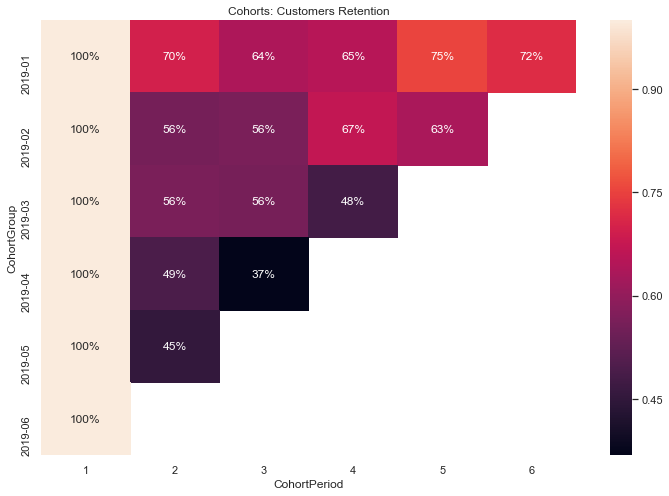

In [35]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: Customers Retention')
sns.heatmap(customer_retension.T, mask=customer_retension.T.isnull(), annot=True, fmt='.0%')

###### Amazing Observasions here...
1. The first cohort, January customers, is the strongest. **What is making them to stick around?**
2. Fewer customers tend to purchase as time goes by. *Apart from Jan and Feb Cohorts* 
3. The newer the customers are, the smaller the retenstion rate. Most New customer do not stay. *Like,  only 37% of customers we gained on April $(902)$ have bought from us* Why?

Sample out customers from April cohort who have not bought from us again and know why... 


#### Cohorts Purchase behaviour.
Lets See if the retentions are corelating with the cylinders sold.

If we are loosing customers with big purchases. 

In [43]:
cohort_total_quantity = cohorts['TotalSales'].groupby(level=0).first()
cohort_total_quantity.head()

CohortGroup
2019-01    239798
2019-02     14640
2019-03      5528
2019-04      9477
2019-05     14056
Name: TotalSales, dtype: int64

In [83]:
cohorts[['TotalCustomers','TotalSales']]

TotalCustomers  TotalSales
CohortGroup CohortPeriod                            
2019-01     1                       4579      239798
            2                       3197      184485
            3                       2919      161726
            4                       2989      173131
            5                       3449      204565
            6                       3295      147827
2019-02     1                        977       14640
            2                        545       13112
            3                        551       16154
            4                        654       20088
            5                        618       16112
2019-03     1                        590        5528
            2                        333        5229
            3                        330        6046
            4                        283        4865
2019-04     1                        902        9477
            2                        445        7335
            3                        332        4473
2019-05     1                       1331       14056
            2                        604        9213
2019-06     1                        535        8405

*The newer customers are relatively buying fewer cylinders. More energy should be on retaiting customers.*

**More Explanation on this...At excel**

In [45]:
cohort_sales=cohorts.TotalSales.unstack(0)
cohort_sales

CohortGroup,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
CohortPeriod,,,,,,
1,239798.0,14640.0,5528.0,9477.0,14056.0,8405.0
2,184485.0,13112.0,5229.0,7335.0,9213.0,NaN
3,161726.0,16154.0,6046.0,4473.0,NaN,NaN
4,173131.0,20088.0,4865.0,NaN,NaN,NaN
5,204565.0,16112.0,NaN,NaN,NaN,NaN
6,147827.0,NaN,NaN,NaN,NaN,NaN


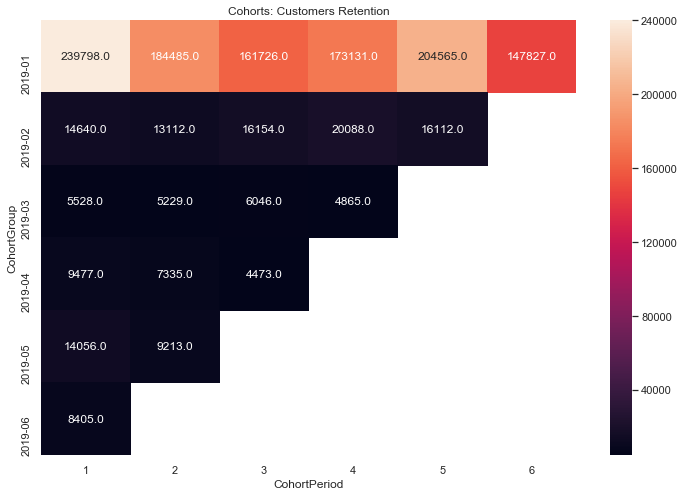

In [60]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: Customers Cylinders Purchase Behaviours')
sns.heatmap(cohort_sales.T, mask=cohort_sales.T.isnull(), annot=True,fmt='')

Since we have discovered that the customers in the first cohort. We wish to understand, apart from the month of the first purchase, what else do they have in common that makes them stick around and remain royal. 

How are they distributed per teritory?

In [85]:
Jan_cohort=df1[df1['CohortGroup']=="2019-01"]
Jan_cohort.groupby('Territory')['CustomerName'].nunique()

Territory
Coast               2
Eastern           192
Mt. Kenya         733
Nairobi East       21
Nairobi North    1517
Nairobi South    1473
Nyanza            295
Rift Valley       253
Western           339
Name: CustomerName, dtype: int64

This table shows the total number of distinct customers 

In [109]:
royal=Jan_cohort[Jan_cohort['PurchaseMonth']=='2019-06']
royal.to_csv("Royal_jan.csv")
royal.groupby('Territory')['CustomerName'].nunique()

Territory
Coast               1
Eastern           125
Mt. Kenya         448
Nairobi North    1196
Nairobi South    1076
Nyanza            191
Rift Valley       161
Western           235
Name: CustomerName, dtype: int64

In [91]:
df1.groupby('Territory')['CustomerName'].nunique()

Territory
Coast              44
Eastern           701
Mt. Kenya        1114
Nairobi East       21
Nairobi North    2759
Nairobi South    2490
Nyanza            511
Rift Valley       726
Western           830
Name: CustomerName, dtype: int64

In [28]:
feb_cust=df1[df1['CohortGroup']=="2019-02"]
feb_cust.groupby('Territory')['CustomerName'].nunique()

Territory
Coast              1
Eastern           85
Mt. Kenya        106
Nairobi North    224
Nairobi South    322
Nyanza            31
Rift Valley       94
Western          130
Name: CustomerName, dtype: int64

In [29]:
feb_cust.to_csv("Feb_customers.csv")

In [97]:
April_cohort=df1[df1['CohortGroup']=="2019-04"]
April_cohort.to_csv("April_customers.csv")

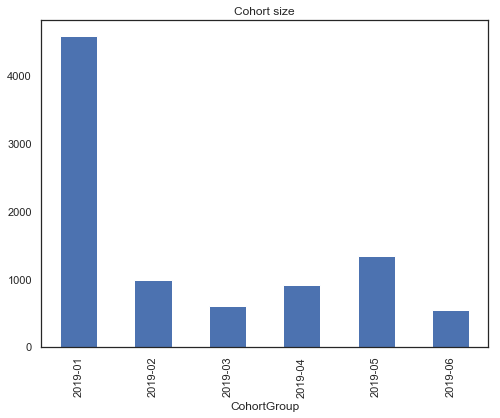

In [107]:
cohort_group_size.plot(kind='bar',figsize=(8,6),title='Cohort size')

   *Muturi*

In [12]:
df1.to_csv('Customers0.csv')

In [ ]:
try:
    n=int(input("Enter a nonzero integer : "))
except ValueError:
    print("You did not enter a nonzero integer. Try again ")
except KeyError:
    print("You entered zero. Try again")
else:0
        reciprocal=int(float(1/n))
        reciprocal=0
print("The reciprocal of {0} is{1: .3f}".format(n, reciprocal))